In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [35]:
df = pd.read_csv('../data/nuclear_overview_after_eda.csv', parse_dates=['Date']) # parse_dates convert column to datetime index
df.head()

,Date,Year,Month,"Nuclear Generating Units, Net Summer Capacity",Nuclear Electricity Net Generation,Nuclear Share of Electricity Net Generation,"Nuclear Generating Units, Capacity Factor"
0,1973-01-01,1973,January,14.533,6246,3.9,57.8
1,1973-02-01,1973,February,14.533,5928,4.1,60.7
2,1973-03-01,1973,March,15.314,6649,4.5,58.4
3,1973-04-01,1973,April,15.314,5876,4.2,53.4
4,1973-05-01,1973,May,16.174,5697,3.9,47.3


In [36]:
# data preprocessing
df_daily = df.set_index('Date').resample('D').asfreq()
df_daily.drop(columns=['Nuclear Generating Units, Net Summer Capacity', 'Nuclear Share of Electricity Net Generation', 'Nuclear Generating Units, Capacity Factor'], inplace=True)
df_daily[['Nuclear Electricity Net Generation']] = df_daily[['Nuclear Electricity Net Generation']].interpolate(method='linear')
df_daily.rename(columns={'Nuclear Electricity Net Generation': 'y_true'}, inplace=True)
df_daily.reset_index(inplace=True)
df_daily['Year'] = df_daily['Date'].dt.year
df_daily['Month'] = df_daily['Date'].dt.month

# data normalization
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df_daily[['y_true']])
df_daily['y_scaled'] = y_scaled
df_daily.head(10)

,Date,Year,Month,y_true,y_scaled
0,1973-01-01,1973,1,6246.000000,-2.233241
1,1973-01-02,1973,1,6235.741935,-2.233766
2,1973-01-03,1973,1,6225.483871,-2.234292
3,1973-01-04,1973,1,6215.225806,-2.234817
4,1973-01-05,1973,1,6204.967742,-2.235342
5,1973-01-06,1973,1,6194.709677,-2.235868
6,1973-01-07,1973,1,6184.451613,-2.236393
7,1973-01-08,1973,1,6174.193548,-2.236918
8,1973-01-09,1973,1,6163.935484,-2.237444
9,1973-01-10,1973,1,6153.677419,-2.237969


<Axes: xlabel='Date', ylabel='y_true'>

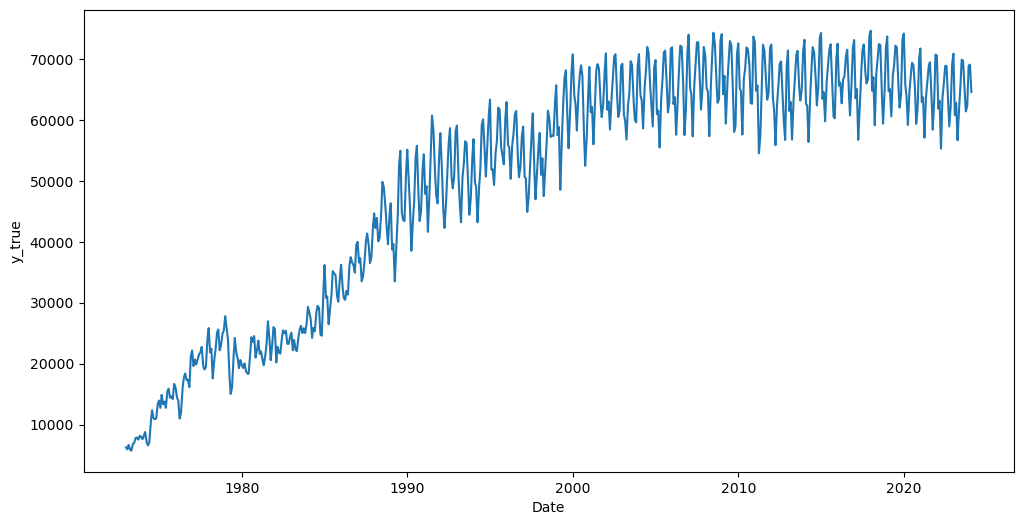

In [37]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily, x='Date', y='y_true')

<Axes: xlabel='Date', ylabel='y_scaled'>

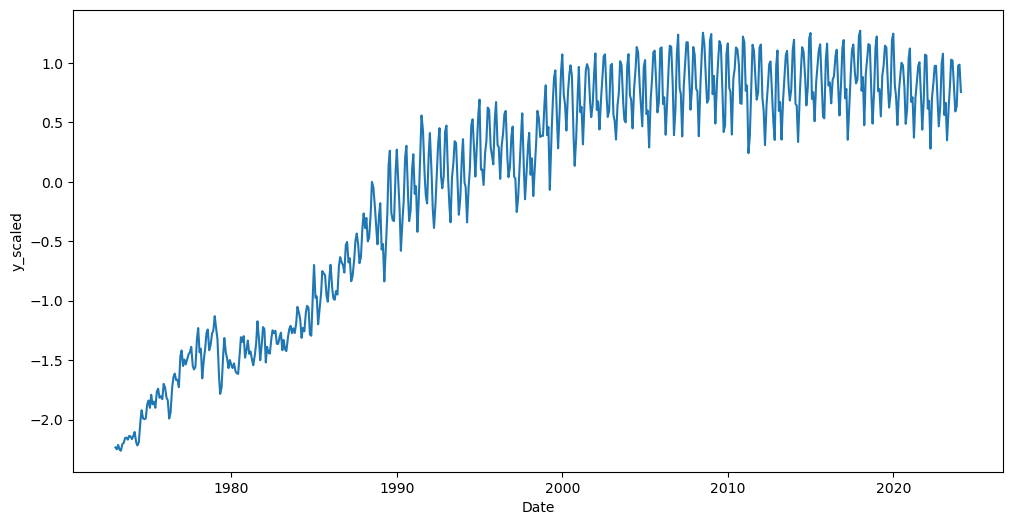

In [38]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_daily, x='Date', y='y_scaled')

In [39]:
# stationarity checking using ADF test (necessary condition for ARIMA)
adfuller_checked = adfuller(df_daily['y_scaled'].dropna())

print(f"ADF Statistic (Original): {adfuller_checked[0]:.4f}")
print(f"p-value (Original): {adfuller_checked[1]:.4f}")

if adfuller_checked[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# the p-value shows that it is stationary but let's difference to be sure

ADF Statistic (Original): -3.0166
p-value (Original): 0.0334
Interpretation: The original series is Stationary.



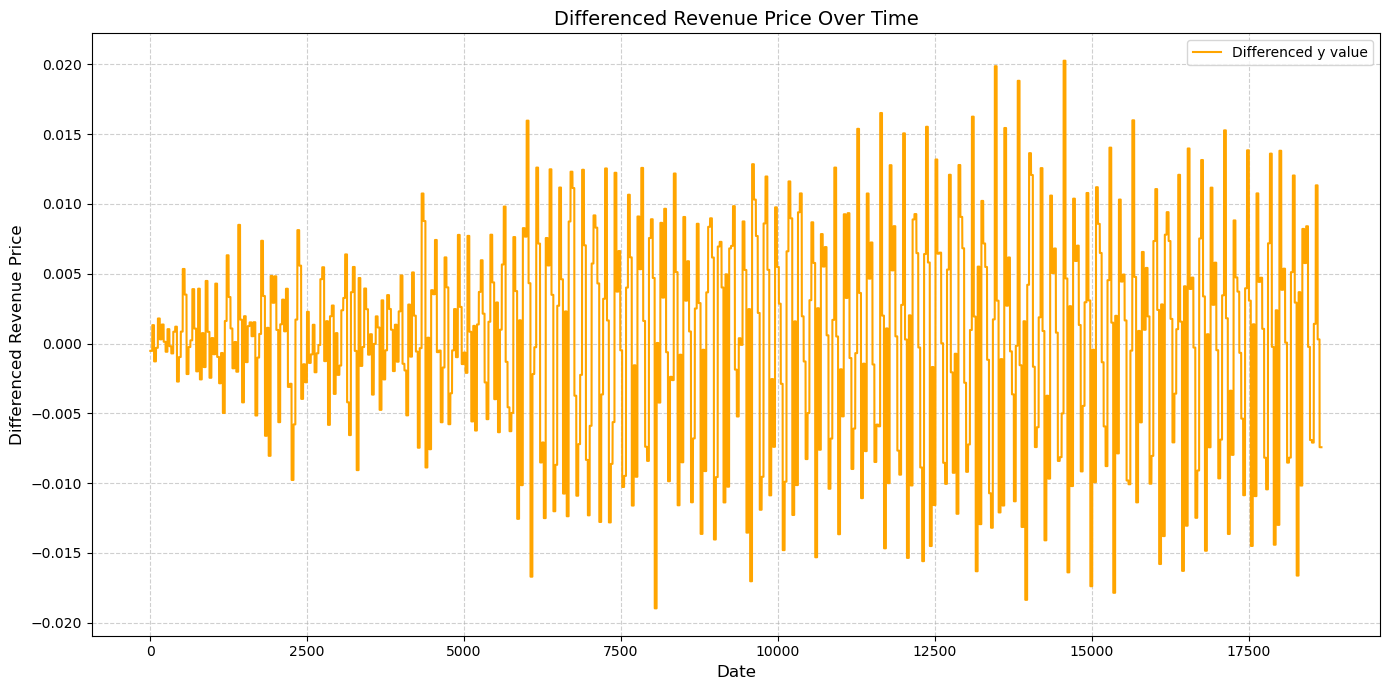

In [40]:
df_daily['y_scaled_diff'] = df_daily['y_scaled'].diff()

# differenced data
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['y_scaled_diff'], label='Differenced y value', color='orange')
plt.title('Differenced Revenue Price Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Differenced Revenue Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

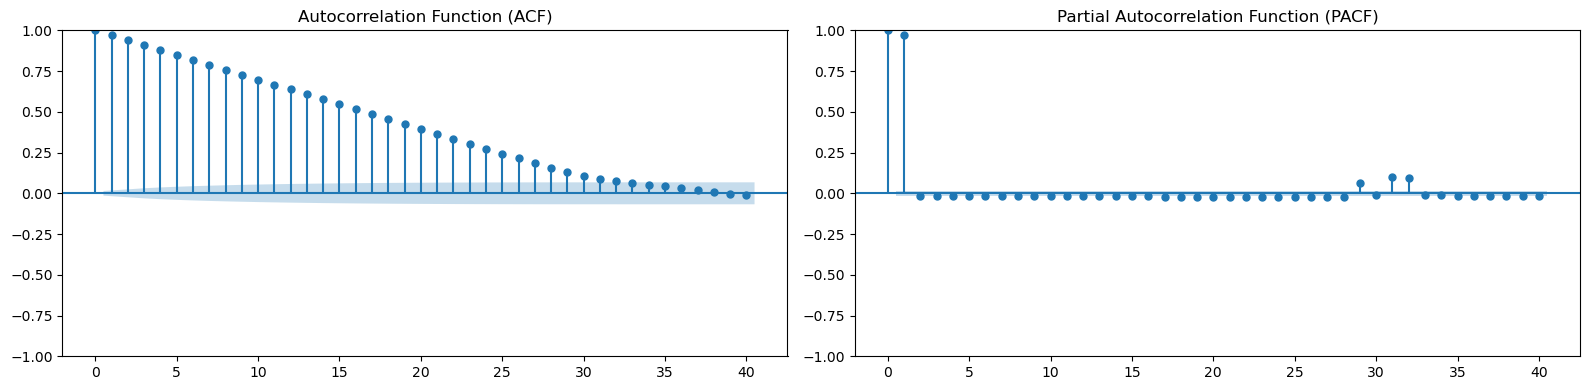

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Autocorrelation Function
plot_acf(df_daily['y_scaled_diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function
plot_pacf(df_daily['y_scaled_diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [42]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

acf_vals = acf(df_daily['y_scaled'].dropna(), nlags=40)
threshold = 0.5
count_acf = (abs(acf_vals) > threshold).sum()
print("ACF values > threshold:", count_acf)

pacf_vals = pacf(df_daily['y_scaled'].dropna(), nlags=40)
threshold = 0.5
count_pacf = (abs(pacf_vals) > threshold).sum()
print("PACF values > threshold:", count_pacf)

ACF values > threshold: 41
PACF values > threshold: 2


In [43]:
# --- Split sales_over_time into training and testing sets
train_size = int(len(df_daily) * 0.80)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

# --- Fit ARIMA model (p=5, d=1, q=2)
order = (5, 1, 2)
model = ARIMA(train['y_scaled'], order=order)
model_fit = model.fit()

c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
forecast

18659    0.747185
18660    0.740330
18661    0.733810
18662    0.727672
18663    0.722041
           ...   
18774   -0.066587
18775   -0.074011
18776   -0.081283
18777   -0.089119
18778   -0.096816
Name: predicted_mean, Length: 120, dtype: float64

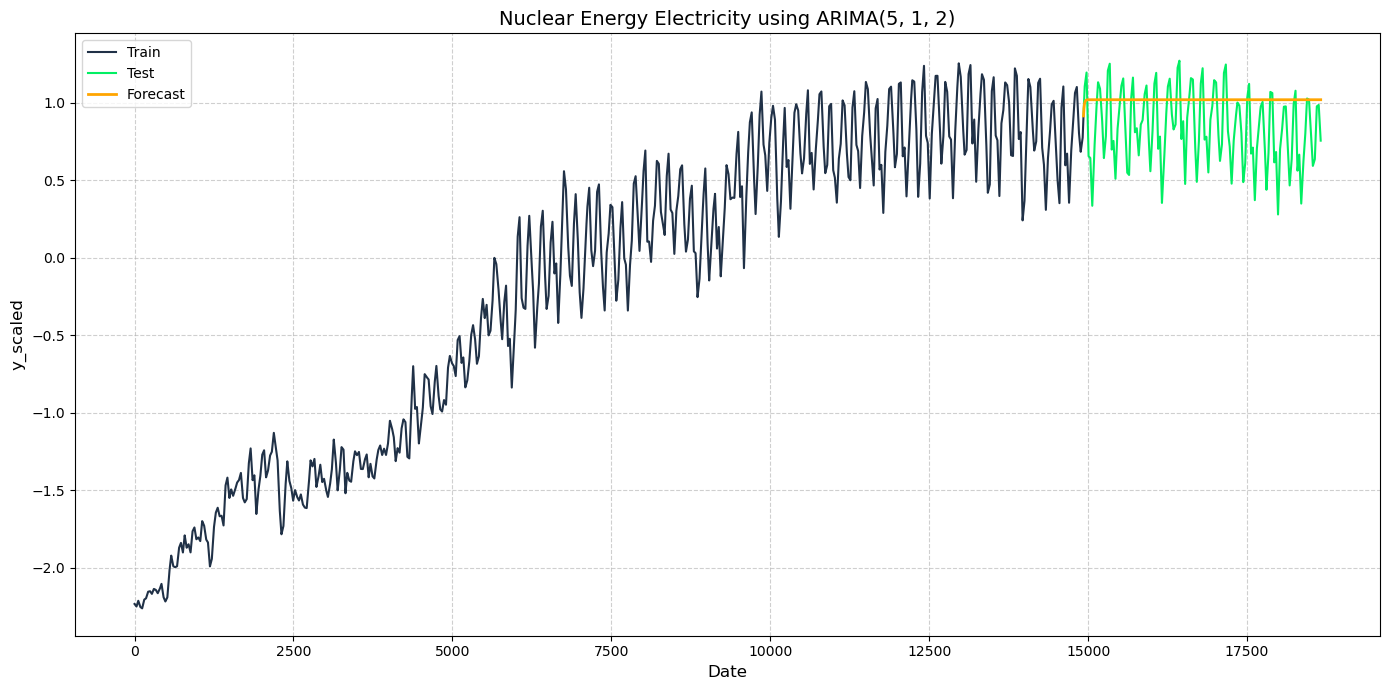

In [45]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['y_scaled'], label='Train', color='#203147')
plt.plot(test.index, test['y_scaled'], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange', linewidth=2)

plt.title(f'Nuclear Energy Electricity using ARIMA{order}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('y_scaled', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## ARIMA Auto-Fit Method

In [46]:
# ARIMA auto-fit method
import pmdarima as pm

auto_arima = pm.auto_arima(train['y_scaled'], seasonal=False, stepwise=True)
auto_arima

,order,"(5, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,True
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,{}
,trend,None
,with_intercept,False


In [47]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                14927
Model:               SARIMAX(5, 1, 0)   Log Likelihood               73523.237
Date:                Sat, 22 Nov 2025   AIC                        -147034.473
Time:                        09:28:13   BIC                        -146988.808
Sample:                             0   HQIC                       -147019.318
                              - 14927                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9844      0.086     11.459      0.000       0.816       1.153
ar.L2      -7.967e-14      0.122  -6.55e-13      1.000      -0.238       0.238
ar.L3      -9.109e-14      0.122  -7.49e-13      1.000      -0.238       0.238
ar.L4      -8.313e-14      0.122  -6.84e-13      1.000      -0.238       0.238
ar.L5         -0.0157      0.086     -0.183      0.855      -0.184       0.153
sigma2      3.082e-06   9.46e-09    325.736      0.000    3.06e-06     3.1e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           4376782.23
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.64   Skew:                             1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        86.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.02e+14. Standard errors may be unstable.
"""

In [48]:
len(test)
forecast_auto = auto_arima.predict(n_periods=len(test))
forecast_auto

14927    0.914333
14928    0.924449
14929    0.934237
14930    0.943703
14931    0.952850
           ...   
18654    1.215441
18655    1.215441
18656    1.215441
18657    1.215441
18658    1.215441
Length: 3732, dtype: float64

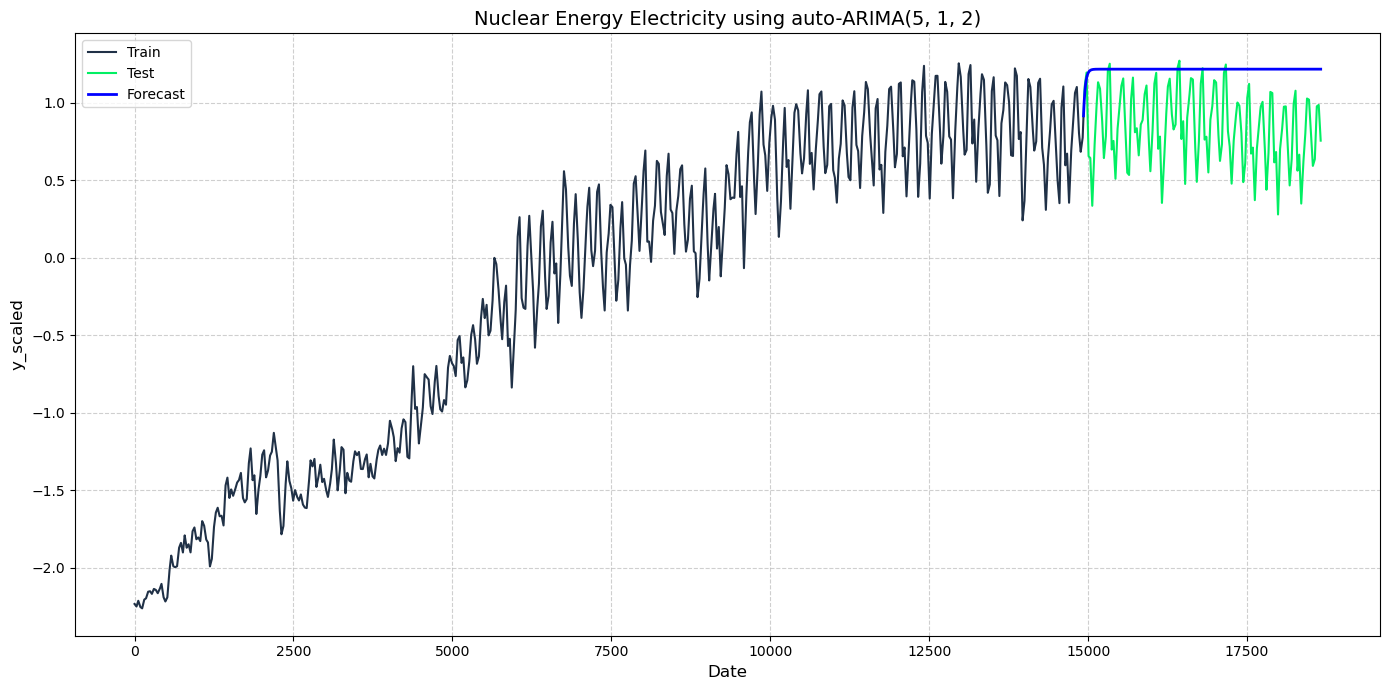

In [49]:
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['y_scaled'], label='Train', color='#203147')
plt.plot(test.index, test['y_scaled'], label='Test', color='#01ef63')
plt.plot(test.index, forecast_auto, label='Forecast', color='blue', linewidth=2)

plt.title(f'Nuclear Energy Electricity using auto-ARIMA{order}', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('y_scaled', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Evaluate both method

In [50]:
# evaluation

mae = mean_absolute_error(test['y_scaled'], forecast)
mape = mean_absolute_percentage_error(test['y_scaled'], forecast)
rmse = np.sqrt(mean_squared_error(test['y_scaled'], forecast))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.2242
Mean Absolute Percentage Error (MAPE): 0.3463
Root Mean Squared Error (RMSE): 0.2769


In [51]:
mae = mean_absolute_error(test['y_scaled'], forecast_auto)
mape = mean_absolute_percentage_error(test['y_scaled'], forecast_auto)
rmse = np.sqrt(mean_squared_error(test['y_scaled'], forecast_auto))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.3760
Mean Absolute Percentage Error (MAPE): 0.5598
Root Mean Squared Error (RMSE): 0.4310


## SARIMA

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [53]:
p, d, q = 5, 1, 2
P, D, Q, s = 5, 1, 2, 12

model = SARIMAX(train['y_scaled'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


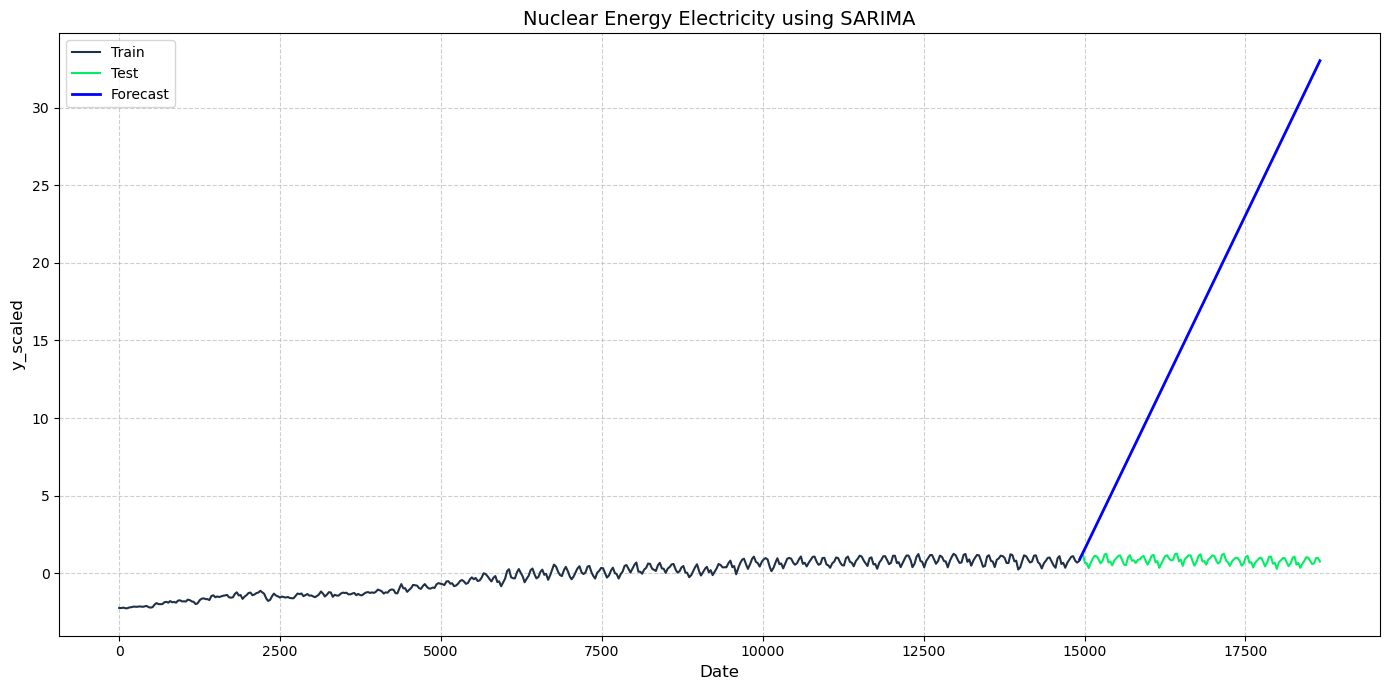

In [ ]:
forecast_sar = results.forecast(steps=len(test))

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['y_scaled'], label='Train', color='#203147')
plt.plot(test.index, test['y_scaled'], label='Test', color='#01ef63')
plt.plot(test.index, forecast_sar, label='Forecast', color='blue', linewidth=2)
plt.title(f'Nuclear Energy Electricity using SARIMA', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('y_scaled', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
